In [1]:
import sys
import os

import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [4]:
sys.version

'3.7.3 (default, Apr 24 2019, 15:29:51) [MSC v.1915 64 bit (AMD64)]'

In [5]:
os.listdir()

['.git',
 '.ipynb_checkpoints',
 'iris.csv',
 'iris_classifcation.ipynb',
 'LICENSE',
 'README.md']

In [6]:
data = pd.read_csv('iris.csv', sep='|', decimal='.')
data.head()

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
1,5.1,3.5,1.4,0.2,setosa
2,4.9,3.0,1.4,0.2,setosa
3,4.7,3.2,1.3,0.2,setosa
4,4.6,3.1,1.5,0.2,setosa
5,5.0,3.6,1.4,0.2,setosa


In [7]:
def print_missing_values(df):
    for col in df.columns:
        print(f'Kolumna {col} ma {pd.isnull(df[col]).sum()} braków danych')

print_missing_values(data)

Kolumna Sepal.Length ma 0 braków danych
Kolumna Sepal.Width ma 1 braków danych
Kolumna Petal.Length ma 0 braków danych
Kolumna Petal.Width ma 0 braków danych
Kolumna Species ma 0 braków danych


In [8]:
# uzupełniamy brakującą wartość w Sepal.Width średnia z kolumny
data['Sepal.Width'].fillna(data['Sepal.Width'].mean(), inplace=True)

In [9]:
print_missing_values(data)

Kolumna Sepal.Length ma 0 braków danych
Kolumna Sepal.Width ma 0 braków danych
Kolumna Petal.Length ma 0 braków danych
Kolumna Petal.Width ma 0 braków danych
Kolumna Species ma 0 braków danych


In [10]:
data.dtypes

Sepal.Length    float64
Sepal.Width     float64
Petal.Length    float64
Petal.Width      object
Species          object
dtype: object

Zauważamy, że jedna zmienna zamiast zmiennej zmiennoprzecinkowej jest zmienną nieilościową. Prawdopodobnie chodzi o separator dziesiętny.

In [11]:
data["Petal.Width"][130:140]

131    1.9
132      2
133    2,2
134    1.5
135    1.4
136    2.3
137    2.4
138    1.8
139    1.8
140    2.1
Name: Petal.Width, dtype: object

In [12]:
# Jedna z obserwacji miała ',' jako separator dziesiętny, dlatego zamieniam na '.'
data["Petal.Width"] = [x.replace(',', '.') for x in data["Petal.Width"]]
data["Petal.Width"] = pd.to_numeric(data["Petal.Width"])

In [13]:
data.dtypes

Sepal.Length    float64
Sepal.Width     float64
Petal.Length    float64
Petal.Width     float64
Species          object
dtype: object

In [14]:
data.describe()

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width
count,150.000000,150.000000,150.000000,150.000000
mean,5.779333,3.061745,3.758000,1.199333
std,1.197721,0.432504,1.765298,0.762238
min,-4.800000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


Zauważamy, że w kolumnie Sepal.Length prawdopodobnie znajduje sie błąd, ponieważ występuje tam obserwacja z długością ujemną. Traktujemy to jako błąd przy wprowadzaniu danych i zamieniamy na odpowiadającą wartość dodatnią.

In [15]:
data['Sepal.Length'] = [abs(x) for x in data['Sepal.Length']]

In [16]:
data.describe()

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.061745,3.758000,1.199333
std,0.828066,0.432504,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


## Wizualizacja zbioru

Celem tej części jest graficzne ukazanie rozkładów zmiennych.

#### Funckja gęstości prezentująca porównanie rozkładów poszczególnych zmiennych:

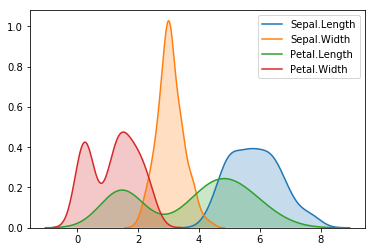

In [17]:
for col in data.columns[:-1]:
    sns.kdeplot(data[col], shade=True)

#### Histogramy oraz funkcja gęstości poszczególnych zmiennych dla każdego gatunku:

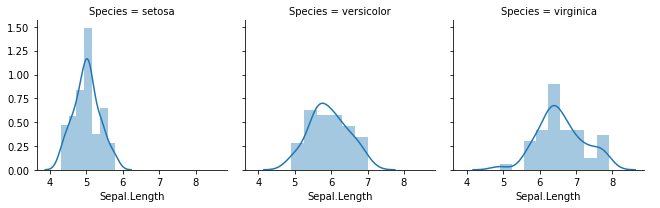

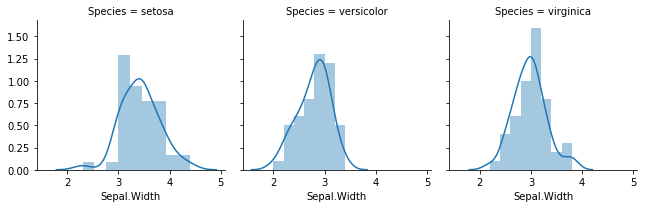

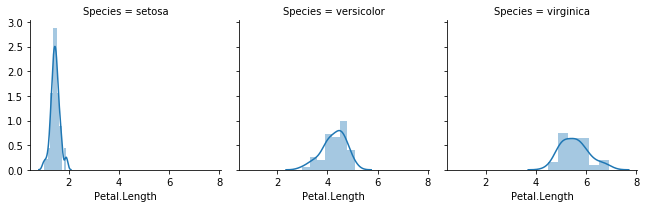

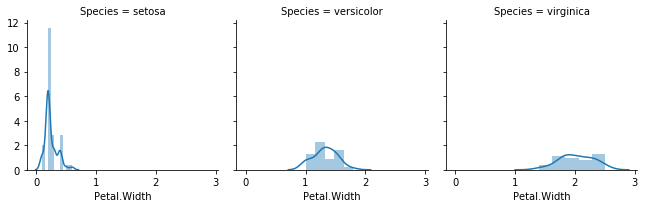

In [18]:
for col in data.columns[:-1]:
    g = sns.FacetGrid(data, col="Species")
    g.map(sns.distplot, col)
    g.add_legend()

#### Wykresy pudełkowe poszczególnych zmiennych dla każdego gatunku:

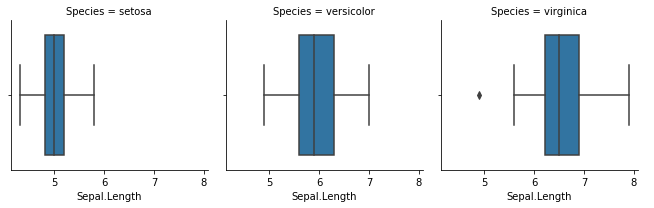

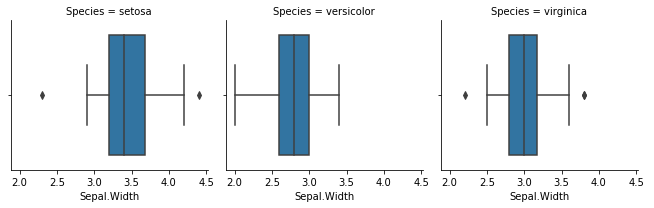

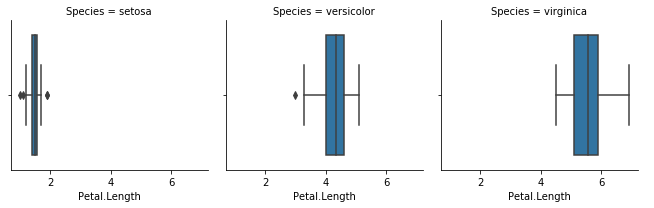

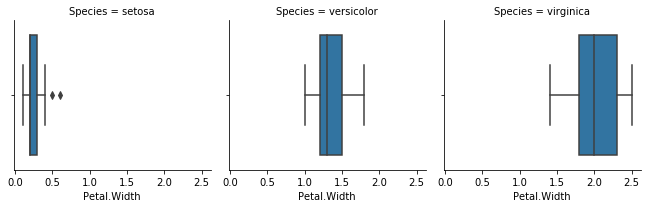

In [19]:
for col in data.columns[:-1]:
    g = sns.FacetGrid(data, col="Species")
    g.map(sns.boxplot, col)
    g.add_legend()

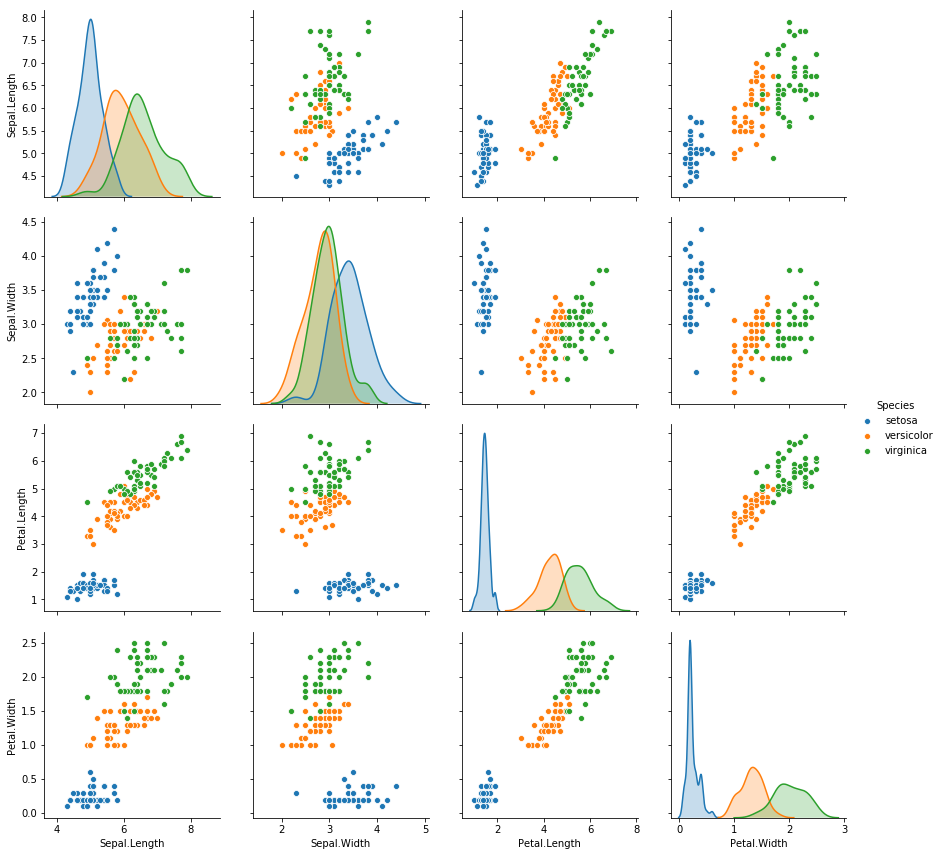

In [20]:
sns.pairplot(data, hue='Species', diag_kind='kde', size=3);

Podział wykresów względem gatunku kwiatu umożliwił pokazanie różnic w wartościach dla poszczególnych zmiennych. Jasno określone granice widoczne m. in. na powyższym wykresie posłużą w dalszej części w tworzeniu klasyfikatora. Co warto zauważyć, kwiat setosa, ma wartości dość mocno różniące się od pozostałych 2 kwiatów. W przypadku kolejnych dwóch kwiatów, ich wartości są do siebie zbliżone, jednak w większości przypadków widać dzielącą ich granicę.

Wykres (3, 3) pokazuje dość wysoką dodatnią korelację Petal.length od Petal.width. Sprawdźmy:

In [21]:
data.corr()

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width
Sepal.Length,1.000000,-0.122741,0.871754,0.817941
Sepal.Width,-0.122741,1.000000,-0.432108,-0.371657
Petal.Length,0.871754,-0.432108,1.000000,0.962865
Petal.Width,0.817941,-0.371657,0.962865,1.000000


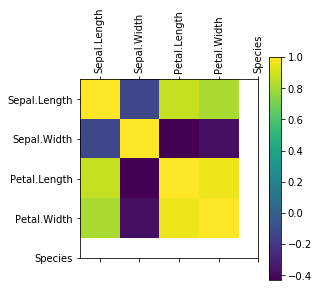

In [22]:
plt.matshow(data.corr())
plt.xticks(range(len(data.columns)), data.columns, rotation=90)
plt.yticks(range(len(data.columns)), data.columns)
plt.colorbar()
plt.show()

Korelacja w poszczególnych gatunkach:

In [23]:
for gatunek in np.unique(data.Species):
    print(f"Korelacjaw obrębie gatunku: {gatunek}")
    print(data[data['Species'] == gatunek].corr())
    print('\n')

Korelacjaw obrębie gatunku: setosa
              Sepal.Length  Sepal.Width  Petal.Length  Petal.Width
Sepal.Length      1.000000     0.742547      0.267176     0.278098
Sepal.Width       0.742547     1.000000      0.177700     0.232752
Petal.Length      0.267176     0.177700      1.000000     0.331630
Petal.Width       0.278098     0.232752      0.331630     1.000000


Korelacjaw obrębie gatunku: versicolor
              Sepal.Length  Sepal.Width  Petal.Length  Petal.Width
Sepal.Length      1.000000     0.492659      0.754049     0.546461
Sepal.Width       0.492659     1.000000      0.512459     0.596807
Petal.Length      0.754049     0.512459      1.000000     0.786668
Petal.Width       0.546461     0.596807      0.786668     1.000000


Korelacjaw obrębie gatunku: virginica
              Sepal.Length  Sepal.Width  Petal.Length  Petal.Width
Sepal.Length      1.000000     0.457228      0.864225     0.281108
Sepal.Width       0.457228     1.000000      0.401045     0.537728
Petal.Length 

# Budowa klasyfikatora

Kolejnym etapem jest budowa klasyfikatora. W telegraficznym skrócie, jego zadaniem będzie klasyfikowanie obserwacji o określonych wartościach zmiennych do konkretnego gatunku kwiatu. Umożlwi to naszemu dostawcy kwiatów określenie gatunku na podstawie wartości 4 zmiennych.

Klasyfikacja kwiatów jest problemem uczenia nadzorowanego. Oznacza to, że dysponujemy wartościami zmiennej celu i chcemy na podstawie wartości zmiennych objaśniająych w jak najbardziej efektywny sposób przewidywać gatunek kwiatu. Istnieje wiele różnych algorytmów klasyfikujących, tj.: najbliższych sąsiadów, naiwny kalsyfikator bayesowski, las losowy, drzewo decyzyjne, support vector machine.

Z uwagi, że celem tego raportu nie jest porównywanie modeli, do klasyfikacji zostanie użyty algorytm KNN, czyli najbliższych sąsiadów.

**Algorytm najbliższych sąsiadów** polega na kalsyfikacji obiektu do grupy na podstawie jego 'bliskości' względem kolejnych obserwacji. Określa się granice decyzyjne i w zależności, do której grupy trafi obiekt zostanie on zaklasyfikowany do odpowiedniej grupy/klasy. Algorytm bazuje na określeniu hiperparametru **k**, który określa na podstawie ilu najbliższych sąsiadów będziemy decydować, do której klasy nasz nowy obiekt zostanie zaklasyfikowany. Odległości między punktami (sąsiadami) obliczane są najczęściem przy użyciu [odległości Euklidesowej](http://www.algorytm.edu.pl/wstep/44-odlego-midzy-punktami.html) lub [odległości Minkowskiego](https://www.sciencedirect.com/topics/computer-science/minkowski-distance).

Nasz zbiór jest dobrze zbilansowany - dla każdej zmiennej mamy dokładnie po 50 obserwacji.

In [24]:
data.Species.value_counts()

virginica     50
setosa        50
versicolor    50
Name: Species, dtype: int64

Dzielimy nasz zbiór na treningowy i testowy. Pierwszy z nich służy do 'wytrenowania' naszego modelu, czyli w naszym przypadku, do określenia granic decyzyjnych. Zbiór testowy wykorzystamy do oceny jak nasz model poprawnie przewiduje obserwacje, których wcześniej nie widział. Zbió testowy będzie stanowił 25% obserwacji.

In [35]:
X = data[data.columns[:-1]]
y = data[data.columns[-1]]

In [36]:
from sklearn.model_selection import train_test_split

In [48]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.25, random_state=123)

In [49]:
X_train.shape, X_test.shape

((112, 4), (38, 4))

In [50]:
Y_train.shape, Y_test.shape

((112,), (38,))

Importujemy klasyfikator KNN i sprawdzimy jak wielkość **k** wpływa na dokładność predykcji:

In [51]:
from sklearn.neighbors import KNeighborsClassifier

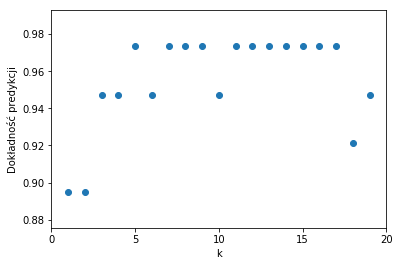

In [52]:
k_range = range(1,20)
scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, Y_train)
    scores.append(knn.score(X_test, Y_test))

plt.figure()
plt.xlabel('k')
plt.ylabel('Dokładność predykcji')
plt.scatter(k_range, scores)
plt.xticks([0, 5, 10, 15, 20]);

Widzimy, że m. in. dla k=5 jakość naszego modelu jest na bardzo wysokim poziomie i wynosi 98%. Oznacza to, że w 98% jestesmy w stanie poprawnie zaklasyfikować gatunek kwiatu.

Warto zastanowić, że również jak podział zbioru wpływa poziom predykcji:

Text(0, 0.5, 'Dokładność predykcji')

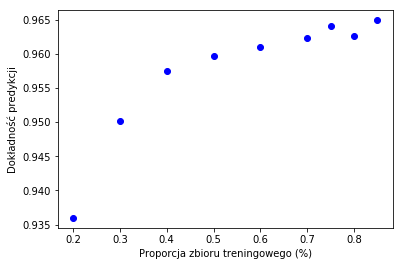

In [53]:
t = [0.85, 0.8, 0.75, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2]

knn = KNeighborsClassifier(n_neighbors = 5)

plt.figure()

for s in t:

    scores = []
    for i in range(1,1000):
        X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 1-s)
        knn.fit(X_train, Y_train)
        scores.append(knn.score(X_test, Y_test))
    plt.plot(s, np.mean(scores), 'bo')

plt.xlabel('Proporcja zbioru treningowego (%)')
plt.ylabel('Dokładność predykcji')

Decydujemy się na podział zbioru w proporcji 75% zbiór treningowy i 25% zbiór testowy oraz k=5:

In [54]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.25, random_state=123)

In [55]:
knn = KNeighborsClassifier(n_neighbors=5)

knn.fit(X_train, Y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [69]:
print(f"Dokładność predykcji: {round(knn.score(X_test, Y_test), 4)*100}%")

Dokładność predykcji: 97.37%


Osiągnięto 97.37% dokładność predykcji. Oznacza to, że w 97.37% jesteśmy w stanie poprawnie zaklasyfikować gatunek kwiatu.